<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-RFR" data-toc-modified-id="Модель-RFR-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель RFR</a></span></li><li><span><a href="#Модель-LGBM" data-toc-modified-id="Модель-LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LGBM</a></span></li><li><span><a href="#Модель-XGB" data-toc-modified-id="Модель-XGB-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель XGB</a></span></li><li><span><a href="#Свод-результатов" data-toc-modified-id="Свод-результатов-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Свод результатов</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Введение

Цель: Построить модель для предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Ход работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

Для начала проведем импорт всех необходимых библиотек и модулей.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

from numpy.random import RandomState

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import make_column_transformer

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV, 
    RandomizedSearchCV,
    TimeSeriesSplit
)

from statsmodels.tsa.seasonal import seasonal_decompose

Напишем функцию для первичного знакомства с данными

In [2]:
def get_data_info(df):
    display (df.head())
    display (df.info())
    display (df.describe())

Преобразуем столбец datetime: изменим тип данных с object на datetime64, установим столбец datetime в качестве индекса.

In [3]:
data = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col=[0])
get_data_info(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверим в каком порядке расположены даты: если в хронологическом, атрибут вернет True.

In [4]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


## Анализ

Выполним ресемплирование по одному часу, исходя из условия задачи о прогнозировании данных на следующий час.

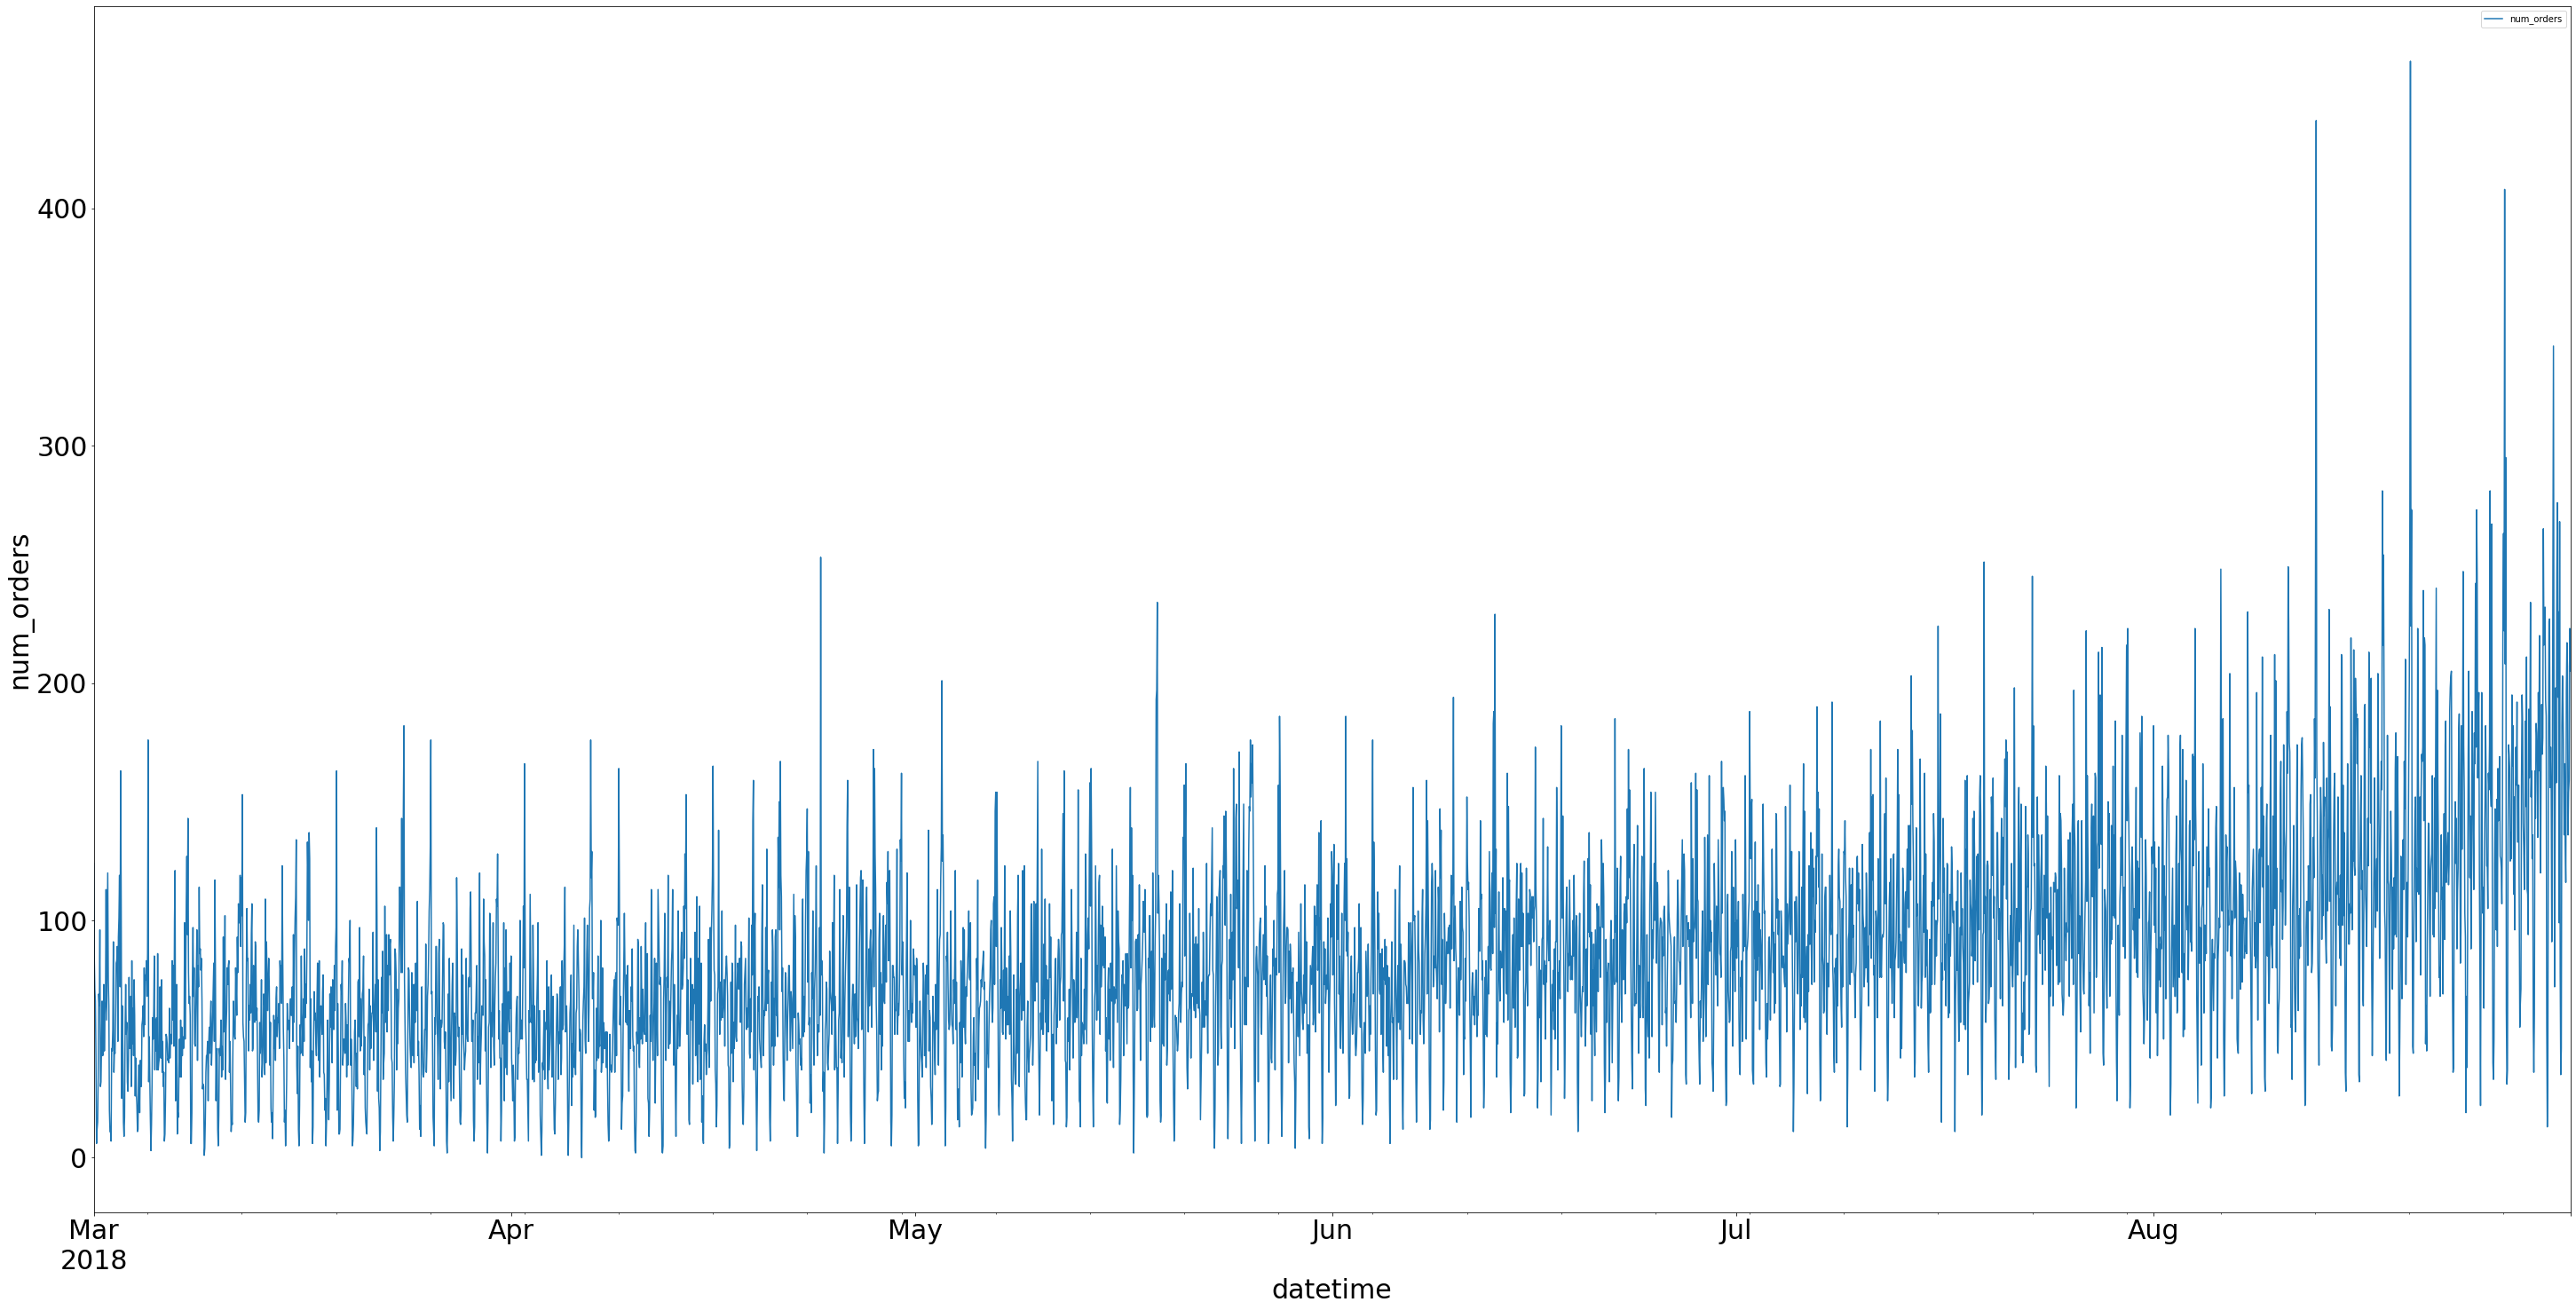

In [5]:
data = data.resample('1H').sum()
data.plot(figsize=(50,25),fontsize = 30);

plt.xlabel('datetime', fontsize = 30)
plt.ylabel('num_orders', fontsize = 30)
plt.show()

In [6]:
data.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [7]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Данные охватывают временной промежуток с 2018-03-01 00:00:00 по 2018-08-31 23:00:00. Также по графику видим, что временной ряд имеет тренд к увеличению к осенним месяцам.

In [8]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Построим график количества заказов в течение августа.

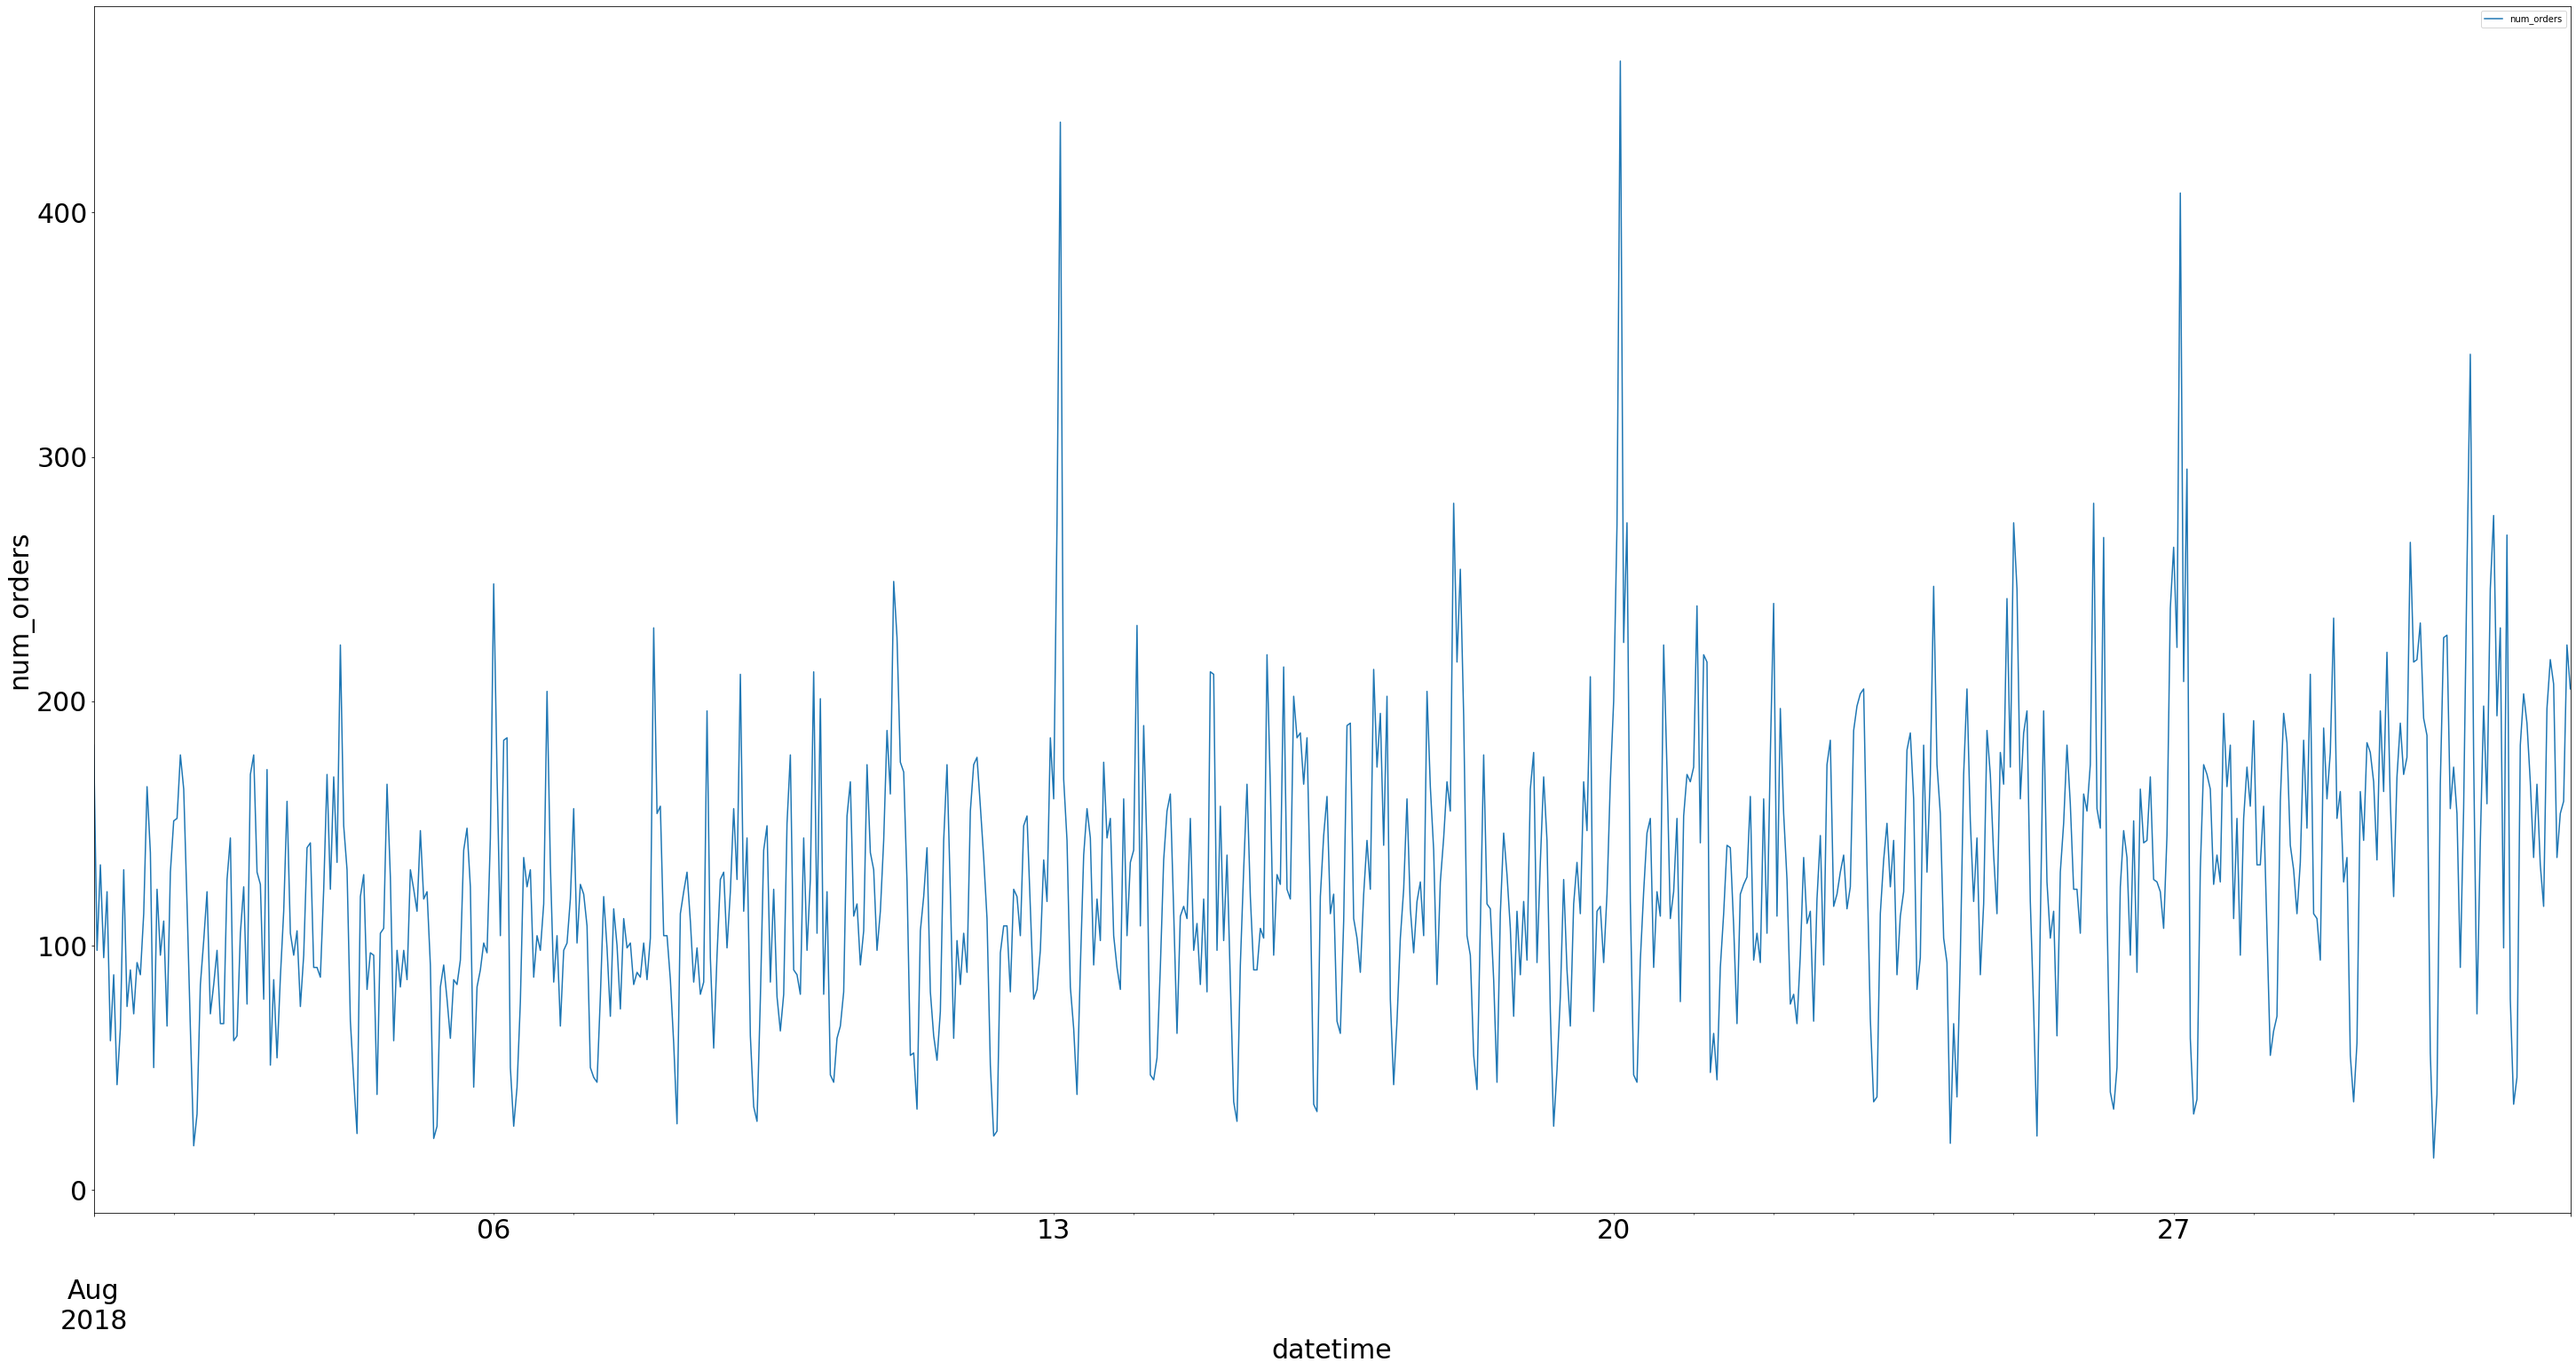

In [9]:
data['2018-08-01 00:00:00': '2018-08-31 23:00:00'].plot(figsize=(50,25),fontsize = 30);

plt.xlabel('datetime', fontsize = 30)
plt.ylabel('num_orders', fontsize = 30)
plt.show()

Видим, что на графике отсутствует четкая зависимость количества заказов от времени, при этом среднее плавно растет, а стандартное отклонение, за исключением 3 выбросов, практически постоянно. Можем сделать вывод о том, что распределение заказов близко к стохастическому стационарныму процессу.

Разберем временной ряд на тренд, сезонность и остатки и построим графики для каждого параметра.

In [10]:
decomposed = seasonal_decompose(data)
decomposed.trend

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: H, Name: trend, Length: 4416, dtype: float64

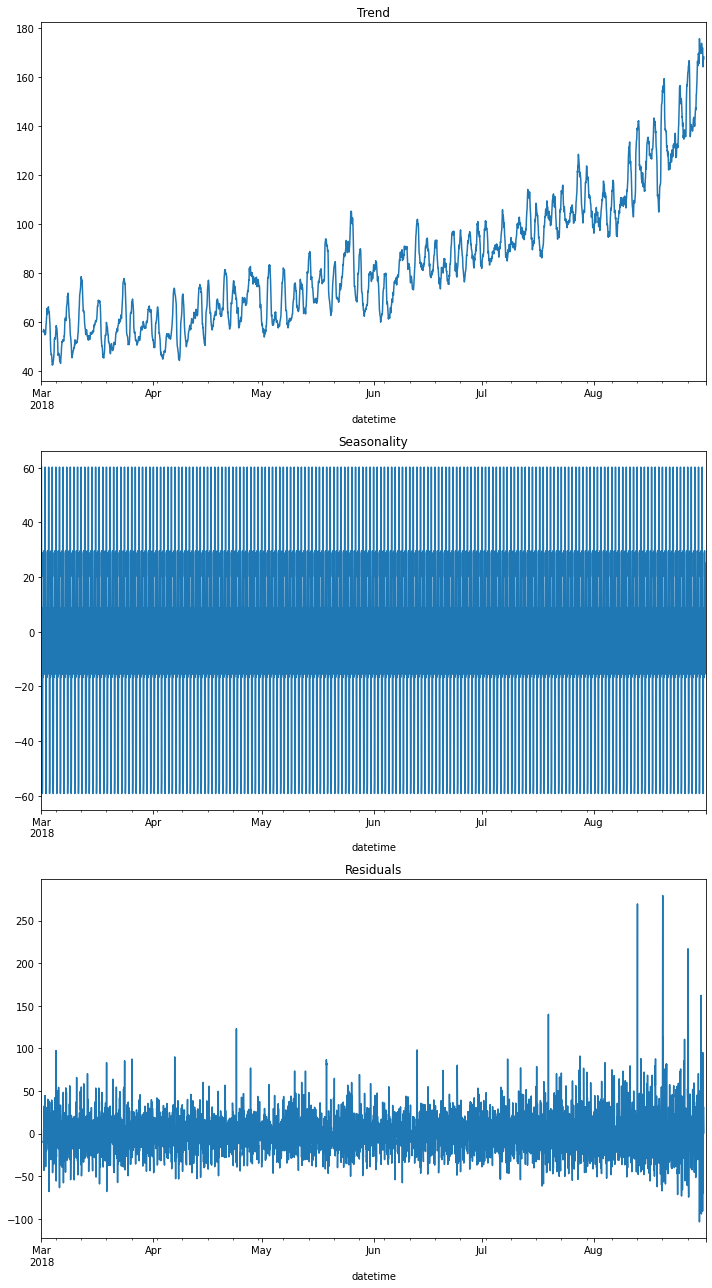

In [11]:
plt.figure(figsize=(10, 18))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Подтвердили, что тренд временного ряда растет в течение рассматриваемого периода, сезонность необходимо рассмотреть детально в течении недели и суток.

<AxesSubplot:xlabel='datetime'>

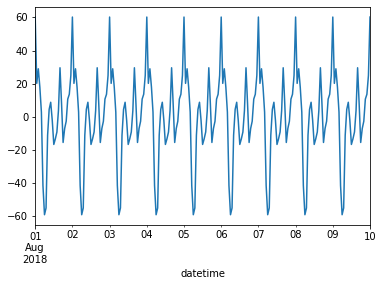

In [12]:
decomposed.seasonal['2018-08-01 00:00:00':'2018-08-10 00:00:00'].plot()

<AxesSubplot:xlabel='datetime'>

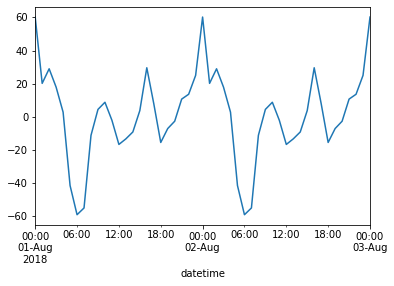

In [13]:
decomposed.seasonal['2018-08-01 00:00:00':'2018-08-03 00:00:00'].plot()

Видим, что заказы циклично меняются в зависимости от времени суток: в часы пик их больше.

## Обучение

Напишем функцию для создания признаков временного ряда, по которым будем обучать модель:
- календарные,
- отстающие признаки, которые укажут модели, как будет себя вести функция: расти или падать,
- скользящее среднее, с помощью которого выберем наиболеее оптимальный характер сглаживания функции.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()

Главной задачей проекта является корректный подбор значений max_lag и rolling_mean_size, на основании которых будет создан набор данных для обучения модели. Для скользящего среднего наиболее подходящим является поиск средних арифметических за сутки, т.е. 24 часа. Количество отстающих значений логично взять за неделю - то есть 168 часов.

In [15]:
make_features(data, 168, 24)

In [16]:
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train,test = train_test_split(data, shuffle=False, test_size=0.1)

In [18]:
train = train.dropna()

In [19]:
train

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,2018,3,8,3,94.0,127.0,108.0,76.0,50.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,2018,3,8,3,143.0,94.0,127.0,108.0,76.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,2018,3,8,3,78.0,143.0,94.0,127.0,108.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,2018,3,8,3,65.0,78.0,143.0,94.0,127.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,2018,3,8,3,68.0,65.0,78.0,143.0,94.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,2018,8,13,0,91.0,39.0,66.0,83.0,143.0,...,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,136.0,134.041667
2018-08-13 10:00:00,156,2018,8,13,0,137.0,91.0,39.0,66.0,83.0,...,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,135.250000
2018-08-13 11:00:00,144,2018,8,13,0,156.0,137.0,91.0,39.0,66.0,...,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,137.250000


In [20]:
X_train = train.drop('num_orders',axis = 1)
Y_train = train['num_orders']

In [21]:
X_test = test.drop('num_orders',axis = 1)
Y_test = test['num_orders']

In [22]:
X_train

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,2018,3,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,2018,3,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,2018,3,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,2018,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,2018,3,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,2018,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,136.0,134.041667
2018-08-13 10:00:00,2018,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,135.250000
2018-08-13 11:00:00,2018,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,137.250000


In [23]:
Y_train

datetime
2018-03-08 00:00:00    143
2018-03-08 01:00:00     78
2018-03-08 02:00:00     65
2018-03-08 03:00:00     68
2018-03-08 04:00:00     60
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3806, dtype: int64

In [24]:
X_test

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,2018,8,13,0,119.0,92.0,144.0,156.0,137.0,91.0,...,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,138.541667
2018-08-13 15:00:00,2018,8,13,0,102.0,119.0,92.0,144.0,156.0,137.0,...,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,138.458333
2018-08-13 16:00:00,2018,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,...,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,139.541667
2018-08-13 17:00:00,2018,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,...,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,139.166667
2018-08-13 18:00:00,2018,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,...,125.0,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,140.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,164.875000
2018-08-31 20:00:00,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,167.541667
2018-08-31 21:00:00,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,168.041667


In [25]:
Y_test

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 442, dtype: int64

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

### Модель линейной регрессии

In [27]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [28]:
model_lr = LinearRegression() 

model_lr.fit(X_train,Y_train) 
scores_lr = cross_val_score (model_lr,X_train_lr,Y_train,cv=tscv,\
                                   scoring = 'neg_root_mean_squared_error')
final_score_lr = scores_lr.mean()*(-1)
print('RMSE на валид выборке при использовании LR:', final_score_lr)

RMSE на валид выборке при использовании LR: 22.57894985573961


### Модель RFR

In [29]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [30]:
state = RandomState(12345)

In [31]:
model_rf = RandomForestRegressor()

In [32]:
param_grid_rf = {
    'n_estimators': range(20, 100, 20),
    'max_depth': range(2, 14, 2),
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [33]:
rs_rf = RandomizedSearchCV(
        estimator = model_rf,
        param_distributions = param_grid_rf,
        scoring = 'neg_root_mean_squared_error',
        cv=tscv,
        n_jobs = -1,
        random_state=state)

In [34]:
rs_rf.fit(X_train_rf, Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': range(2, 14, 2),
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': range(20, 100, 20)},
                   random_state=RandomState(MT19937) at 0x7F21843E3E40,
                   scoring='neg_root_mean_squared_error')

In [35]:
rs_rf_best_score = rs_rf.best_score_ * -1
rs_rf_best_params = rs_rf.best_params_
print(f'best_score: {rs_rf_best_score}')
print(f'best_params: {rs_rf_best_params}')

best_score: 22.80958488633376
best_params: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 12}


### Модель LGBM

In [36]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

In [37]:
model_lgbm = LGBMRegressor()

In [38]:
param_grid_lgbm = {
    'max_depth': [5, 6],
    'learning_rate': [.2, .3],
}

In [39]:
gs_lgbm = GridSearchCV(
        estimator = model_lgbm,
        param_grid = param_grid_lgbm,
        scoring = 'neg_root_mean_squared_error',
        cv=tscv,
        verbose = 3,
        n_jobs = -1)

In [40]:
gs_lgbm.fit(X_train_lgbm, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .................learning_rate=0.2, max_depth=5; total time= 1.5min
[CV 2/5] END .................learning_rate=0.2, max_depth=5; total time= 1.8min
[CV 3/5] END .................learning_rate=0.2, max_depth=5; total time= 2.0min
[CV 4/5] END .................learning_rate=0.2, max_depth=5; total time= 2.0min
[CV 5/5] END .................learning_rate=0.2, max_depth=5; total time= 2.2min
[CV 1/5] END .................learning_rate=0.2, max_depth=6; total time= 2.0min
[CV 2/5] END .................learning_rate=0.2, max_depth=6; total time= 2.3min
[CV 3/5] END .................learning_rate=0.2, max_depth=6; total time= 2.7min
[CV 4/5] END .................learning_rate=0.2, max_depth=6; total time= 2.9min
[CV 5/5] END .................learning_rate=0.2, max_depth=6; total time= 3.0min
[CV 1/5] END .................learning_rate=0.3, max_depth=5; total time= 1.7min
[CV 2/5] END .................learning_rate=0.3, 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3], 'max_depth': [5, 6]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [41]:
gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'best_score: {gs_lgbm_best_score}')
print(f'best_params: {gs_lgbm_best_params}')

best_score: 23.5576949213031
best_params: {'learning_rate': 0.2, 'max_depth': 6}


### Модель XGB

In [42]:
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

In [43]:
from xgboost import XGBRegressor

In [44]:
model_xgb = XGBRegressor()

In [45]:
param_grid_xgbm = {
    'max_depth': [5, 6],
    'learning_rate': [.2, .3],
}

In [46]:
gs_xgbm = GridSearchCV(
        estimator = model_xgb,
        param_grid = param_grid_xgbm,
        scoring = 'neg_root_mean_squared_error',
        cv=tscv,
        verbose = 3,
        n_jobs = -1)

In [47]:
gs_xgbm.fit(X_train_xgb, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .................learning_rate=0.2, max_depth=5; total time= 1.4min
[CV 2/5] END .................learning_rate=0.2, max_depth=5; total time= 1.5min
[CV 3/5] END .................learning_rate=0.2, max_depth=5; total time= 1.6min
[CV 4/5] END .................learning_rate=0.2, max_depth=5; total time= 1.5min
[CV 5/5] END .................learning_rate=0.2, max_depth=5; total time= 1.6min
[CV 1/5] END .................learning_rate=0.2, max_depth=6; total time= 1.9min
[CV 2/5] END .................learning_rate=0.2, max_depth=6; total time= 2.0min
[CV 3/5] END .................learning_rate=0.2, max_depth=6; total time= 2.2min
[CV 4/5] END .................learning_rate=0.2, max_depth=6; total time= 2.2min
[CV 5/5] END .................learning_rate=0.2, max_depth=6; total time= 2.2min
[CV 1/5] END .................learning_rate=0.3, max_depth=5; total time= 1.5min
[CV 2/5] END .................learning_rate=0.3, 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg

In [48]:
gs_xgbm_best_score = gs_xgbm.best_score_ * -1
gs_xgbm_best_params = gs_xgbm.best_params_
print(f'best_score: {gs_xgbm_best_score}')
print(f'best_params: {gs_xgbm_best_params}')

best_score: 23.570916631341298
best_params: {'learning_rate': 0.2, 'max_depth': 5}


### Свод результатов

In [49]:
analysis = pd.DataFrame({
    'LinearRegression' : final_score_lr,
    'Random Forest Regressor' : rs_rf_best_score,
    'LGBMRegressor' : gs_lgbm_best_score,
    'XGBRegressor' : gs_xgbm_best_score
}, index = ['RMSE'])

analysis

,LinearRegression,Random Forest Regressor,LGBMRegressor,XGBRegressor
RMSE,22.57895,22.809585,23.557695,23.570917


## Тестирование

In [50]:
predict_lr = model_lr.predict(X_test_lr)
rmse_lr = mean_squared_error(Y_test, predict_lr, squared=False)
rmse_lr

35.45245286333725

In [51]:
final_result = pd.DataFrame({
    'target' : Y_test,
    'predict' : predict_lr,
}, index = Y_test.index)
final_result

,target,predict
datetime,,
2018-08-13 14:00:00,102,119.00
2018-08-13 15:00:00,175,126.25
2018-08-13 16:00:00,144,186.50
2018-08-13 17:00:00,152,132.50
2018-08-13 18:00:00,104,90.75
...,...,...
2018-08-31 19:00:00,136,116.50
2018-08-31 20:00:00,154,157.00
2018-08-31 21:00:00,159,172.50


Вывод: для окончательного тестирования мы выбрали модель линейной регрессии, итоговый RMSE равен 35, что ниже 48.
Результатом нашего проекта стала модель линейной регресии, которая способна предсказать количество заявок такси на следующий час с заданной точностью.


<AxesSubplot:xlabel='datetime'>

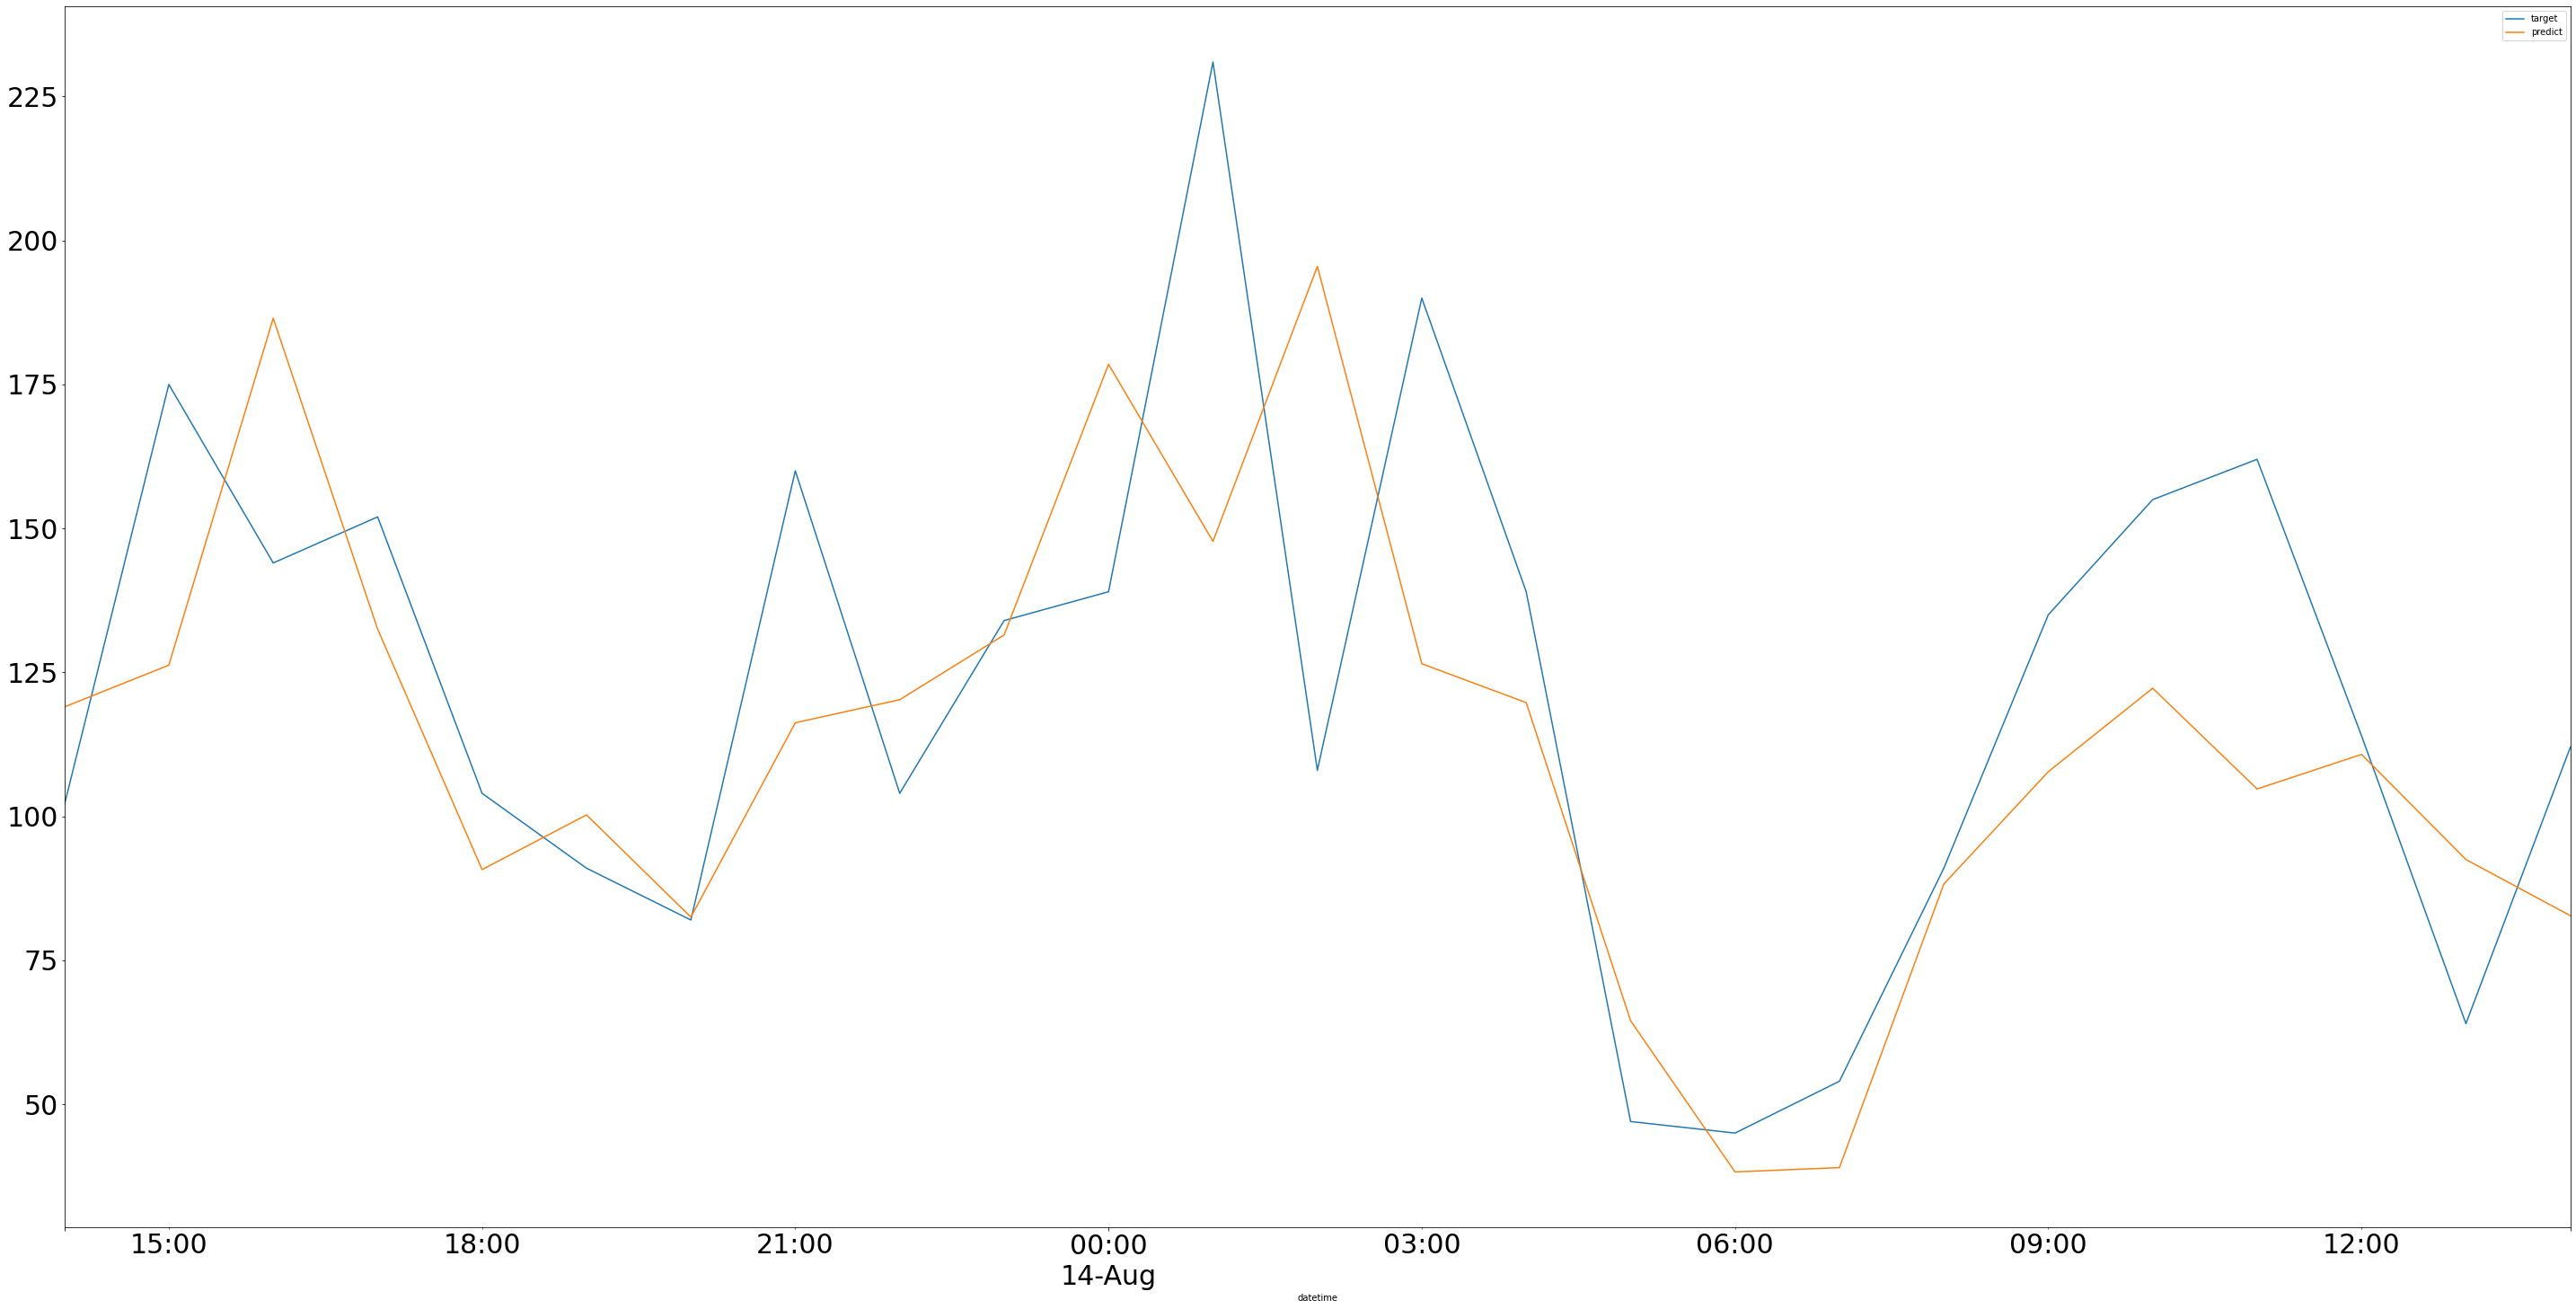

In [52]:
final_result['2018-08-13 14:00:00':'2018-08-14 14:00:00'].plot(figsize=(50,25),fontsize = 30)

In [53]:
final_result['2018-08-13 14:00:00':'2018-08-14 14:00:00']

,target,predict
datetime,,
2018-08-13 14:00:00,102,119.00
2018-08-13 15:00:00,175,126.25
2018-08-13 16:00:00,144,186.50
2018-08-13 17:00:00,152,132.50
2018-08-13 18:00:00,104,90.75
2018-08-13 19:00:00,91,100.25
2018-08-13 20:00:00,82,82.50
2018-08-13 21:00:00,160,116.25
2018-08-13 22:00:00,104,120.25


In [59]:
mean_squared_error (final_result['2018-08-13 14:00:00':'2018-08-14 14:00:00']['target'],final_result['2018-08-13 14:00:00':'2018-08-14 14:00:00']['predict'])**0.5

37.524991672217595

Вывод по графику: предсказанные значения количества заказов отличаются от реальных, тем не менее RMSE на рассматриваемом нами промежутке с 2018-08-13 14:00:00 по 2018-08-14 14:00:00 равно 37.5 и меньше требуемого 48.